检查数据处理和加载是否有问题

In [26]:
import os
import addict
import numpy as np
from tqdm import tqdm
from datasets.dataloader import make_dataloader
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [9]:
cfg = addict.Dict(cfg)
dataset, loader = make_dataloader(cfg, data_type='test', use_cpu=True)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
=> num_images: 100
=> load 100 samples
num_wokers=4


In [11]:
dataset.__len__()

100

In [ ]:
import torch
from utils.visualization_tools import draw_point, draw_bbox
def show_imgs(imgs, joints, bboxes):
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
    imgs = imgs * std + mean
    imgs *= 255
    imgs = torch.permute(imgs, (0,2,3,1)).cpu().numpy().copy().astype(np.int32)

    bs, h, w, c = imgs.shape
    rows = bs // 2
    cols = bs - rows
    idx = 0
    for row in range(rows):
        for col in range(cols):
            img = imgs[idx].copy()
            joint = joints[idx].copy()
            bbox = bboxes[idx].cpu().numpy().copy()
            img = draw_point(img, joint, is_rgb=True)
            img = draw_bbox(img, bbox, xyxy=False)
            plt.subplot(rows, cols, idx+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(img)
            idx += 1
    # plt.title('GT Images')
    plt.show()

In [ ]:
from test.top_down_eval import keypoints_from_heatmaps
def decode(data_meta, output):
    batch_size = output.shape[0]
    bbox_ids = data_meta['bbox_id'].cpu().clone().numpy().tolist()
    score = data_meta['bbox_score'].cpu().clone().numpy()
    image_paths = data_meta['image_file']

    c = data_meta['center'].cpu().clone().numpy()
    s = data_meta['scale'].cpu().clone().numpy()

    preds, maxvals = keypoints_from_heatmaps(
        output.cpu().clone().numpy(),
        c,
        s,
        post_process='unbiased',  # None, 'default', 'unbiased', 'megvii'
        kernel=11,
        use_udp=True,
        target_type='GaussianHeatmap')

    all_preds = np.zeros((batch_size, preds.shape[1], 3), dtype=np.float32)
    all_boxes = np.zeros((batch_size, 6), dtype=np.float32)
    all_preds[:, :, 0:2] = preds[:, :, 0:2]
    all_preds[:, :, 2:3] = maxvals
    all_boxes[:, 0:2] = c[:, 0:2]   # bbox的 中心点
    all_boxes[:, 2:4] = s[:, 0:2]   # bbox的 宽高/200
    all_boxes[:, 4] = np.prod(s * 200.0, axis=1)   # bbox的面积
    all_boxes[:, 5] = score   # bbox的得分

    # for i in range(batch_size):
    result = {}
    result['preds'] = all_preds
    result['boxes'] = all_boxes
    result['image_paths'] = image_paths
    result['bbox_ids'] = bbox_ids
    result['output_heatmap'] = output

    return result

In [ ]:
results = []
for i, data in tqdm(enumerate(loader)):
    if i == 3:        
        print(data.keys())
        imgs = data['img']
        img_size = imgs.shape[2]
        joints = data['joints_3d'].numpy()
        bboxes = data['bbox'] 
        bboxes = [b * img_size / 224  for b in bboxes]
        center = data['center']
        print(f"{center=}")
        print(f"{data['bbox_score']=}")
        print(f"{data['bbox_id']=}")

        print(f"{imgs.shape=}")
        print(f"{bboxes=}")
        print(f"{joints.shape=}")

        show_imgs(imgs, joints, bboxes)
        break
    # results.append(decode(data, data['target']))

In [ ]:
metric_value = dataset.evaluate(results)
metric_value

In [ ]:
from xtcocotools.coco import COCO
from xtcocotools.cocoeval import COCOeval
# from pycocotools.coco import COCO
# from pycocotools.cocoeval import COCOeval
from pathlib import Path
from utils.post_processing.coco_wholebody_evaluation.evaluation_wholebody import *
import json
from utils.post_processing.hand_oks import test_hand_oks

In [ ]:
gt_resuls_file = Path('utils/post_processing/coco_wholebody_evaluation/example_gt.json')
pred_resuls_file = Path('utils/post_processing/coco_wholebody_evaluation/example_pred.json')
with gt_resuls_file.open('r') as fd:
    gt_results = json.load(fd)
with pred_resuls_file.open('r') as fd:
    pred_results = json.load(fd)   

In [ ]:
hand_pred_results = []
for ann in pred_results:
    hand_pred_results.append(dict(
        image_id=ann['image_id'],
        category_id=ann['category_id'],
        keypoints=[1]*51,
        score=1.,
        lefthand_kpts=ann['lefthand_kpts'],
        righthand_kpts=ann['righthand_kpts'],
        lefthand_score=ann['righthand_score'],
        righthand_score=ann['righthand_score'],
    ))
results_file = Path('./hand_pred.json')
json.dump(hand_pred_results, results_file.open('w'))
test_hand_oks(gt_resuls_file, str(results_file))
results_file.unlink(missing_ok=True)   # 删除临时存储的json文件

In [ ]:
coco = COCO(gt_resuls_file)
coco_dt = coco.loadRes(str(pred_resuls_file))
coco_eval = test_lefthand(coco, coco_dt)
coco_eval = test_righthand(coco, coco_dt)
# coco_eval = COCOeval(coco, coco_dt, 'keypoints')
# coco_eval.params.useSegm = None
# coco_eval.evaluate()
# coco_eval.accumulate()
# coco_eval.summarize()
print(f"{coco_eval.stats=}")  # （list）12个值，对于 AP AP50 AP75 ...

In [ ]:
pred_results[0].keys()

In [ ]:
bbox_pred_results = []
for ann in gt_results['annotations']:
    bbox_pred_results.append(dict(
        image_id=ann['image_id'],
        bbox=ann['bbox'],
        score=1.,
        category_id=ann['category_id']
    ))
bbox_pred_file = Path('./example_bbox_pred.json')
json.dump(bbox_pred_results, bbox_pred_file.open('w'))

In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
coco = COCO(gt_resuls_file)
coco_dt = coco.loadRes(str(bbox_pred_file))
coco_eval = COCOeval(coco, coco_dt, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()
print(f"{coco_eval.stats=}")

In [ ]:
preds = json.load(bbox_pred_file.open('r'))
print(f"{type(preds)==list}")

In [1]:
import torch
model_path = 'models/pose_estimation/SRHandNet/srhandnet.pts'
model = torch.jit.load(model_path, map_location=torch.device('cpu'))

In [ ]:
for k, v in model.state_dict().items():
    print(f"k={k:20}\t{v.shape}")

In [ ]:
print(model)

In [4]:
import torch
from models import SRHandNet
net = SRHandNet()
x = torch.rand(2, 3, 352, 352)
y = net(x)

In [5]:
for yi in y:
    print(yi.shape)

torch.Size([2, 24, 22, 22])
torch.Size([2, 24, 22, 22])
torch.Size([2, 24, 44, 44])
torch.Size([2, 24, 88, 88])


In [6]:
dir(torch.optim.lr_scheduler)

['ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'EPOCH_DEPRECATION_WARNING',
 'ExponentialLR',
 'LambdaLR',
 'LinearLR',
 'MultiStepLR',
 'MultiplicativeLR',
 'OneCycleLR',
 'Optimizer',
 'ReduceLROnPlateau',
 'SequentialLR',
 'StepLR',
 '_LRScheduler',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'bisect_right',
 'inf',
 'math',
 'types',
 'warnings',
 'weakref',
 'wraps']

In [4]:
import numpy as np
a = np.random.rand(2, 5)
a

array([[0.91895211, 0.49073976, 0.9436814 , 0.78529941, 0.72831407],
       [0.0660016 , 0.90676372, 0.52049185, 0.38093829, 0.68041664]])

In [20]:
idx = a.argmax(axis=1)
idx

array([2, 1])

In [23]:
a.max(axis=1)

array([[0.9436814 ],
       [0.90676372]])

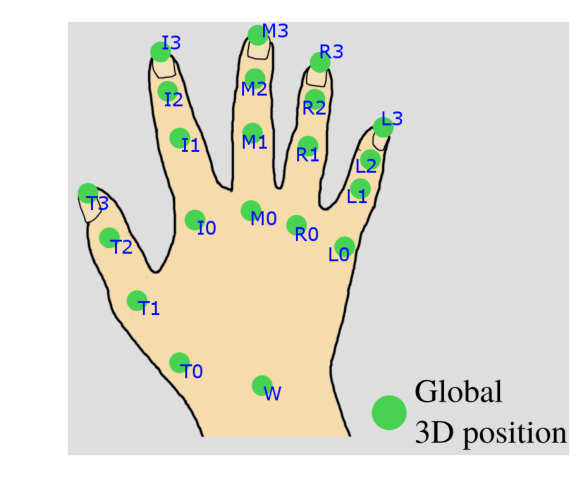

In [28]:
jpg_path = '/root/data/Dataset/GANeratedDataset/GANeratedHands_Release/joints.png'
img = plt.imread(jpg_path)
plt.imshow(img)